In [1]:
import yaml
import os

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np

In [3]:
# Load the configuration file
with open('../config.yaml', 'r') as config_file:
    config = yaml.safe_load(config_file)

# Access the settings
project_folder = config['projectFolder']
df_path = os.path.join(project_folder, config['cleanDataFile'])
df = pd.read_csv(df_path)

# Display the first few rows
df.head()

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,55.2,16.98,3170.410,539.673,399.697,10.15890,1.66910,249.291,248.269,248.313,...,249.774,462.601,488.724,441.674,433.629,448.477,480.866,489.382,67.06,1.11
1,55.2,16.98,3365.650,573.517,399.023,10.08600,1.70565,249.379,253.312,252.092,...,249.060,456.445,440.432,456.625,432.736,464.334,445.950,432.906,66.97,1.27
2,55.2,16.98,2693.750,592.133,409.204,9.94880,1.72472,248.302,251.906,251.115,...,249.236,459.248,480.114,453.814,433.885,438.642,421.974,408.193,66.75,1.36
3,55.2,16.98,2352.216,601.807,398.145,9.84375,1.75928,248.950,246.313,248.071,...,252.686,558.545,548.280,551.960,561.720,543.070,529.260,514.240,66.63,1.34
4,55.2,16.98,3313.960,626.099,399.785,9.74710,1.77000,248.379,250.532,249.434,...,251.323,559.346,534.120,539.332,538.596,545.270,575.404,595.680,66.85,1.15


In [4]:
# Calculate correlations with target variable, excluding non-numeric columns
correlations = df.select_dtypes(include=['number']).corr()['% Silica Concentrate'].sort_values(ascending=False)
print("Top correlations with % Silica Concentrate:")
print(correlations.head(10))
print("\nBottom correlations with % Silica Concentrate:")
print(correlations.tail(10))
print("\n")

Top correlations with % Silica Concentrate:
% Silica Concentrate            1.000000
Amina Flow                      0.136489
% Silica Feed                   0.076246
Ore Pulp Density                0.039613
Flotation Column 02 Level       0.037061
Flotation Column 01 Level       0.022279
Flotation Column 03 Level       0.020732
Flotation Column 04 Air Flow   -0.002232
Ore Pulp Flow                  -0.003730
Flotation Column 05 Air Flow   -0.007626
Name: % Silica Concentrate, dtype: float64

Bottom correlations with % Silica Concentrate:
% Iron Feed                    -0.080823
Flotation Column 06 Level      -0.094601
Flotation Column 04 Level      -0.135836
Flotation Column 07 Level      -0.143992
Ore Pulp pH                    -0.151740
Flotation Column 05 Level      -0.163276
Flotation Column 02 Air Flow   -0.173811
Flotation Column 03 Air Flow   -0.222288
Flotation Column 01 Air Flow   -0.223074
% Iron Concentrate             -0.802008
Name: % Silica Concentrate, dtype: float64




In [5]:
# Extract only numeric columns
numeric_df = df.select_dtypes(include=['number'])

# Calculate correlation matrix
corr_matrix = numeric_df.corr()

# Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Apply the mask by setting upper triangle values to NaN
corr_matrix_masked = corr_matrix.mask(mask)

# Create the heatmap with masked data
fig = px.imshow(
    corr_matrix_masked,  # Use masked correlation matrix
    text_auto=True,
    color_continuous_scale='RdBu',
    zmin=-1,
    zmax=1
)

# Customize the layout
fig.update_layout(
    title='Correlation Matrix (Lower Triangle)',
    xaxis_title='Features',
    yaxis_title='Features',
    width=800,
    height=800
)

# Show the plot
fig.show()

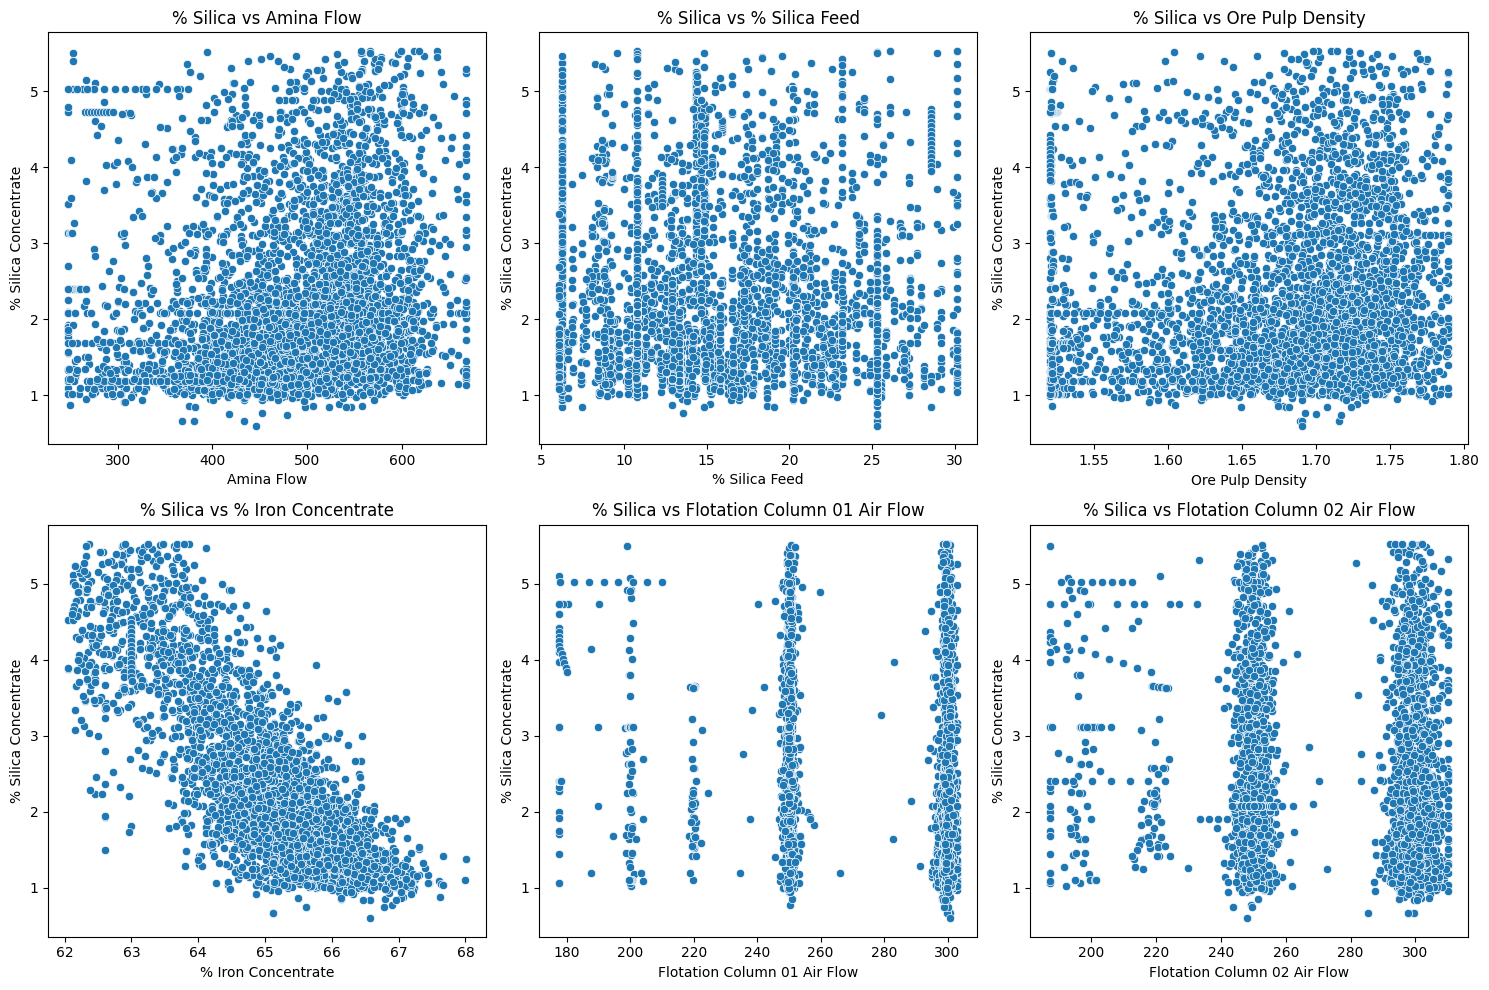

In [6]:
# Define top positive and negative correlated variables
top_positive = ['Amina Flow', '% Silica Feed', 'Ore Pulp Density']
top_negative = ['% Iron Concentrate', 'Flotation Column 01 Air Flow', 'Flotation Column 02 Air Flow']

# Create scatter plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, col in enumerate(top_positive):
    sns.scatterplot(x=df[col], y=df['% Silica Concentrate'], ax=axes[0, i])
    axes[0, i].set_title(f'% Silica vs {col}')

for i, col in enumerate(top_negative):
    sns.scatterplot(x=df[col], y=df['% Silica Concentrate'], ax=axes[1, i])
    axes[1, i].set_title(f'% Silica vs {col}')

plt.tight_layout()
plt.show()

In [7]:
# Set the correlation threshold
threshold = 0.9

# Create a set to store features to remove
features_to_remove = set()

# Iterate through the correlation matrix
for col in corr_matrix.columns:
    for row in corr_matrix.index:
        # Check if the ABSOLUTE correlation is above the threshold and the features are not the same
        if (abs(corr_matrix.loc[row, col]) > threshold) and (row != col):
            # If neither feature has been marked for removal, add one of them to the removal set
            if row not in features_to_remove and col not in features_to_remove:
                features_to_remove.add(row)

print("Features to remove:", features_to_remove)

Features to remove: {'Flotation Column 03 Air Flow', '% Silica Feed'}


In [8]:
# Drop the highly correlated features
df1 = df.drop(columns=features_to_remove)

print("DataFrame after removing highly correlated features:")
df1.head()

DataFrame after removing highly correlated features:


,% Iron Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,55.2,3170.410,539.673,399.697,10.15890,1.66910,249.291,248.269,295.096,306.4,...,249.774,462.601,488.724,441.674,433.629,448.477,480.866,489.382,67.06,1.11
1,55.2,3365.650,573.517,399.023,10.08600,1.70565,249.379,253.312,295.096,306.4,...,249.060,456.445,440.432,456.625,432.736,464.334,445.950,432.906,66.97,1.27
2,55.2,2693.750,592.133,409.204,9.94880,1.72472,248.302,251.906,295.096,306.4,...,249.236,459.248,480.114,453.814,433.885,438.642,421.974,408.193,66.75,1.36
3,55.2,2352.216,601.807,398.145,9.84375,1.75928,248.950,246.313,295.096,306.4,...,252.686,558.545,548.280,551.960,561.720,543.070,529.260,514.240,66.63,1.34
4,55.2,3313.960,626.099,399.785,9.74710,1.77000,248.379,250.532,295.096,306.4,...,251.323,559.346,534.120,539.332,538.596,545.270,575.404,595.680,66.85,1.15


In [9]:
#Add a random uniform column from Yield
# Step 1: Get the range of the column
min_value = df1['% Silica Concentrate'].min()
max_value = df1['% Silica Concentrate'].max()

# Step 2: Generate random uniform values within the range
random_uniform_values = np.random.uniform(min_value, max_value, size=len(df1))

# Step 3: Add the random uniform column to the DataFrame
df1['RandomUniform'] = random_uniform_values

# Display the updated DataFrame
df1

,% Iron Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,...,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate,RandomUniform
0,55.20,3170.410,539.673,399.697000,10.15890,1.66910,249.29100,248.269,295.096,306.400,...,462.601,488.724,441.674,433.629,448.477,480.866,489.382,67.06,1.11,5.407083
1,55.20,3365.650,573.517,399.023000,10.08600,1.70565,249.37900,253.312,295.096,306.400,...,456.445,440.432,456.625,432.736,464.334,445.950,432.906,66.97,1.27,1.550055
2,55.20,2693.750,592.133,409.204000,9.94880,1.72472,248.30200,251.906,295.096,306.400,...,459.248,480.114,453.814,433.885,438.642,421.974,408.193,66.75,1.36,5.017717
3,55.20,2352.216,601.807,398.145000,9.84375,1.75928,248.95000,246.313,295.096,306.400,...,558.545,548.280,551.960,561.720,543.070,529.260,514.240,66.63,1.34,1.254343
4,55.20,3313.960,626.099,399.785000,9.74710,1.77000,248.37900,250.532,295.096,306.400,...,559.346,534.120,539.332,538.596,545.270,575.404,595.680,66.85,1.15,2.600274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3920,49.75,2888.060,494.990,376.921640,9.27990,1.66786,303.00076,297.754,300.583,300.593,...,577.943,489.959,504.995,440.587,481.295,434.701,401.796,65.05,1.65,1.901317
3921,49.75,4218.570,492.027,378.630000,9.15799,1.64888,302.08100,301.348,300.125,299.530,...,412.491,510.388,342.202,371.883,594.518,443.687,375.044,64.83,1.71,1.184593
3922,49.75,3159.100,520.986,381.468667,9.58069,1.73620,296.06300,298.480,299.130,299.588,...,401.456,533.409,390.060,395.463,587.855,489.406,504.982,64.29,1.80,4.315333
3923,49.75,3348.190,511.961,379.684000,9.89000,1.73723,301.65500,298.362,297.533,296.898,...,399.186,520.956,700.739,422.519,585.371,474.397,385.606,64.25,1.96,3.451907


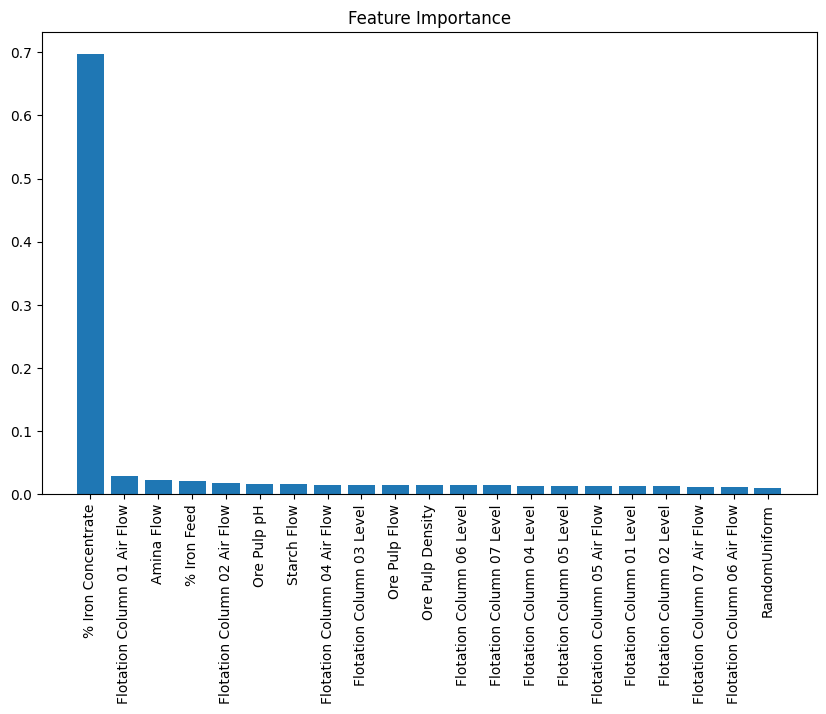

In [10]:
# Feature importance using Random Forest
from sklearn.ensemble import RandomForestRegressor

X = df1.drop(columns=['% Silica Concentrate'])  # Features
y = df1['% Silica Concentrate']  # Target

model = RandomForestRegressor(random_state=42)
model.fit(X, y)

# Plot feature importance
importances = model.feature_importances_
feature_names = X.columns
sorted_indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), importances[sorted_indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[sorted_indices], rotation=90)
plt.title("Feature Importance")
plt.show()

In [11]:
# Create a DataFrame to store feature names and their importances
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Identify features to drop (importance < random uniform value)
# Extract the importance of the RandomUniform column
random_uniform_importance = importance_df[importance_df['Feature'] == 'RandomUniform']['Importance'].values[0]

# Identify features with importance less than the RandomUniform importance
features_to_drop = importance_df[importance_df['Importance'] < random_uniform_importance]['Feature'].tolist()
features_to_drop

[]

In [12]:
# Step 5: Drop the low-importance features
df_reduced = df1.drop(columns=features_to_drop)
df_reduced.drop(columns=['RandomUniform'], inplace=True)
df_reduced

,% Iron Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,55.20,3170.410,539.673,399.697000,10.15890,1.66910,249.29100,248.269,295.096,306.400,...,249.774,462.601,488.724,441.674,433.629,448.477,480.866,489.382,67.06,1.11
1,55.20,3365.650,573.517,399.023000,10.08600,1.70565,249.37900,253.312,295.096,306.400,...,249.060,456.445,440.432,456.625,432.736,464.334,445.950,432.906,66.97,1.27
2,55.20,2693.750,592.133,409.204000,9.94880,1.72472,248.30200,251.906,295.096,306.400,...,249.236,459.248,480.114,453.814,433.885,438.642,421.974,408.193,66.75,1.36
3,55.20,2352.216,601.807,398.145000,9.84375,1.75928,248.95000,246.313,295.096,306.400,...,252.686,558.545,548.280,551.960,561.720,543.070,529.260,514.240,66.63,1.34
4,55.20,3313.960,626.099,399.785000,9.74710,1.77000,248.37900,250.532,295.096,306.400,...,251.323,559.346,534.120,539.332,538.596,545.270,575.404,595.680,66.85,1.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3920,49.75,2888.060,494.990,376.921640,9.27990,1.66786,303.00076,297.754,300.583,300.593,...,302.330,577.943,489.959,504.995,440.587,481.295,434.701,401.796,65.05,1.65
3921,49.75,4218.570,492.027,378.630000,9.15799,1.64888,302.08100,301.348,300.125,299.530,...,342.615,412.491,510.388,342.202,371.883,594.518,443.687,375.044,64.83,1.71
3922,49.75,3159.100,520.986,381.468667,9.58069,1.73620,296.06300,298.480,299.130,299.588,...,332.393,401.456,533.409,390.060,395.463,587.855,489.406,504.982,64.29,1.80
3923,49.75,3348.190,511.961,379.684000,9.89000,1.73723,301.65500,298.362,297.533,296.898,...,226.481,399.186,520.956,700.739,422.519,585.371,474.397,385.606,64.25,1.96


In [13]:
df_reduced.describe()

,% Iron Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
count,3925.000000,3925.000000,3925.000000,3925.000000,3925.000000,3925.000000,3925.000000,3925.000000,3925.000000,3925.000000,...,3925.000000,3925.000000,3925.000000,3925.000000,3925.000000,3925.000000,3925.000000,3925.000000,3925.000000,3925.000000
mean,56.293024,2833.364762,488.085359,397.500566,9.766777,1.680850,280.064866,277.062984,299.442823,299.926067,...,290.766086,520.452849,523.286713,531.594141,421.575527,426.241166,430.972674,421.619552,65.043068,2.333597
std,5.131583,1221.352011,90.702941,9.644884,0.384550,0.068926,29.598607,29.819333,2.565330,3.580891,...,28.826321,131.107835,128.913286,150.202214,90.477129,83.881945,90.196521,84.578366,1.120171,1.129771
min,45.380000,145.773080,247.334300,376.921640,8.754963,1.520103,177.484459,187.280618,294.361643,289.923504,...,195.026000,152.346000,211.336333,127.120281,162.717796,167.225020,159.870000,177.474268,62.050000,0.600000
25%,52.670000,2054.140000,432.908000,394.186000,9.526190,1.647150,250.291000,250.541000,298.225000,298.115828,...,255.860000,417.458000,441.764000,411.138000,357.408000,358.597000,359.397000,357.235000,64.350000,1.440000
50%,56.080000,2989.890000,504.648000,399.240000,9.800220,1.698240,299.360000,296.199000,299.809000,299.825000,...,299.048000,491.978000,496.497000,494.079000,412.561000,409.507194,426.205000,411.116000,65.210000,2.000000
75%,59.720000,3724.610000,555.143000,402.833000,10.036800,1.729080,300.146000,300.680000,300.608000,301.764000,...,301.891000,594.013000,595.650000,601.435000,486.687000,483.063000,494.310000,478.637000,65.850000,3.010000
max,64.030000,5504.236000,668.046440,417.735479,10.583488,1.789418,303.000760,310.053280,305.379955,306.400000,...,371.248000,861.600571,828.599547,886.773000,679.490000,674.076707,698.570061,656.747500,68.010000,5.530000


In [14]:
#df_reduced.to_csv('C:/Users/mjkipsz2/OneDrive - The University of Manchester/Desktop/mining_dataset_training/data/transformed_data.csv', index=False)

In [15]:
# Normalize or standardize features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_reduced.iloc[:, :-1])  # Exclude target column
df_reduced.iloc[:, :-1] = scaled_features
df_norm=df_reduced
df_norm.head()

,% Iron Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,-0.213027,0.275996,0.568826,0.227759,1.019824,-0.170499,-1.039839,-0.965738,-1.694665,1.808142,...,-1.422218,-0.441310,-0.268142,-0.598737,0.133238,0.265119,0.553233,0.801282,1.800787,1.11
1,-0.213027,0.435872,0.942004,0.157869,0.830227,0.359848,-1.036866,-0.796598,-1.694665,1.808142,...,-1.446990,-0.488270,-0.642799,-0.499185,0.123367,0.454182,0.166073,0.133461,1.720431,1.27
2,-0.213027,-0.114326,1.147271,1.213589,0.473401,0.636556,-1.073257,-0.843754,-1.694665,1.808142,...,-1.440884,-0.466888,-0.334940,-0.517902,0.136068,0.147856,-0.099780,-0.158767,1.524008,1.36
3,-0.213027,-0.393998,1.253941,0.066825,0.200190,1.138027,-1.051361,-1.031341,-1.694665,1.808142,...,-1.321186,0.290578,0.193901,0.135607,1.549147,1.392954,1.089841,1.095224,1.416868,1.34
4,-0.213027,0.393545,1.521794,0.236885,-0.051175,1.293576,-1.070655,-0.889838,-1.694665,1.808142,...,-1.368475,0.296688,0.084046,0.051523,1.293536,1.419185,1.601500,2.058241,1.613291,1.15


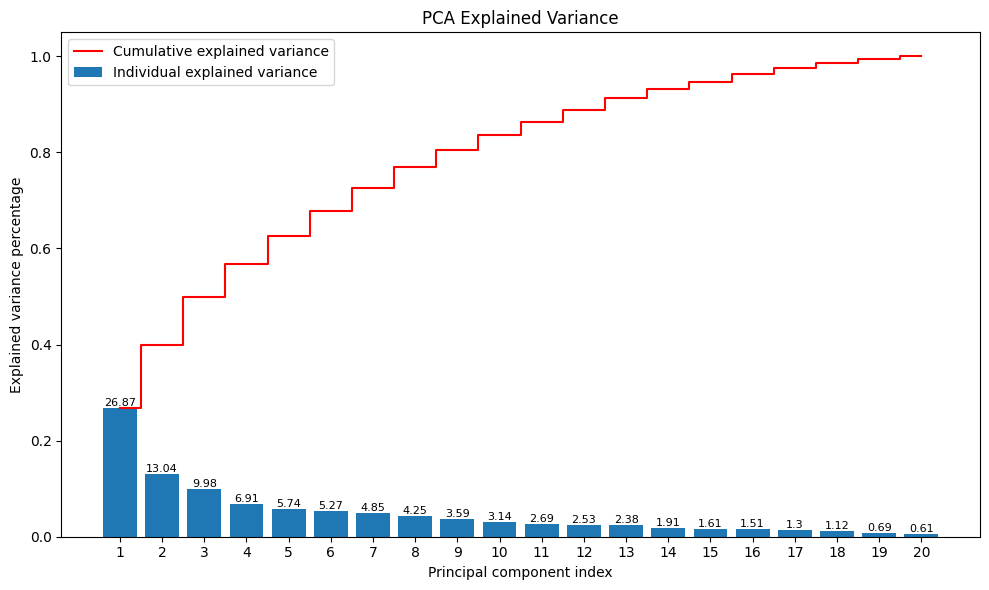

In [16]:
#Dimension Reduction
from sklearn.decomposition import PCA

# Define PCA function
pca = PCA()
pca.fit(df_norm.iloc[:, :-1])  # Exclude target column

# PCA variance explained
exp_var = pca.explained_variance_ratio_
cum_exp_var = exp_var.cumsum()

# Number of components
n_pca_components = len(exp_var)

# Create the graphic
plt.figure(figsize=(10, 6))
bars = plt.bar(range(1, n_pca_components + 1), exp_var, align='center',
               label='Individual explained variance')
plt.step(range(1, n_pca_components + 1), cum_exp_var, where='mid',
         label='Cumulative explained variance', color='red')

# Add labels in each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval*100, 2), 
             va='bottom', ha='center', fontsize=8)

# Adjust others elements of the graphic
plt.ylabel('Explained variance percentage')
plt.xlabel('Principal component index')
plt.xticks(ticks=list(range(1, n_pca_components + 1)))
plt.title('PCA Explained Variance')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [17]:
#df_norm.to_csv('C:/Users/mjkipsz2/OneDrive - The University of Manchester/Desktop/mining_dataset_training/data/transformed_normalized_data.csv', index=False)